# Project 2
Group members: Lena Jörg, Sigurd Kolltveit, Gregor Moe

In [28]:
#import numpy as np
import autograd.numpy as np  # required for automatic differentiation
import matplotlib.pyplot as plt

Runge-Kutta 4 implementation

In [3]:
def rk4_step(v_prev,x_prev,h,f):
    kx1 = h*v_prev
    kv1 = h*f(v_prev,x_prev)

    kx2 = h*(v_prev + kv1/2)
    kv2 = h*f(x_prev + kx1/2, v_prev + kv1/2)

    kx3 = h*(v_prev + kv2/2)
    kv3 = h*f(x_prev + kx2/2, v_prev + kv2/2)

    kx4 = h*(v_prev + kv3)
    kv4 = h*f(x_prev + kx3, v_prev + kv3)

    v = v_prev + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
    x = x_prev + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
    return v, x

def rk4(Tmax,h, v0, x0, B_func, A_func, U_func, gradU_func):
    maxiter = int(Tmax//h)

    vs = np.zeros((maxiter,3))
    xs = np.zeros((maxiter,3))
    vs[0] = v0
    xs[0] = x0
    
    i = 1 
    while i<maxiter: #regner denne iterasjonen
        f = lambda x,v: np.cross(v,B_func(x)) - gradU_func(x)
        vs[i], xs[i] = rk4_step(vs[i-1],xs[i-1],h,f)
        i += 1
    return vs, xs



2D charged particle

In [30]:
def B_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([0,0,np.sqrt(x1**2+x2**2)])

def A_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([-x2*np.sqrt(x1**2+x2**2), x1*np.sqrt(x1**2+x2**2), 0])/3

def U_particle(x):
    x1 = x[0]
    x2 = x[1]
    return 1/(100*np.sqrt(x1**2 + x2**2))

def gradU_particle(x):
    x1 = x[0]
    x2 = x[1]
    u0 = x1/((x1**2 + x2**2)**(3/2))
    u1 = x2/((x1**2 + x2**2)**(3/2))
    return np.array([u0,u1,0])/(-100)

x0_particle = np.array([0.0, 1.0, 0.1], dtype=float)
v0_particle = np.array([0.09, 0.05, 0.20], dtype=float) 

Tokamak magnetic field

In [5]:
def B_tokamak(x):
    x1,x2,x3 = x
    b1 = -(2*x1 + x1*x3)/(2*(x1**2+x2**2))
    b2 = (2*x1 - x2*x3)/(2*(x1**2+x2**2))
    b3 = (np.sqrt(x1**2 + x2**2) - 1)/(2*np.sqrt(x1**2+x2**2))
    return np.array([b1, b2, b3])

def A_tokamak(x):
    x1,x2,x3 = x
    a2 = (x1 - np.log(np.sqrt(x1**2 + x2**2) + x1))/2
    a3 = (x3*np.arctan2(x2, x1) + np.log(x1**2 + x2**2))/(-2)
    return np.array([0, a2, a3])

def U_tokamak(x):
    return 0

def gradU_tokamak(x):
    return np.array([0, 0, 0])

x0_tokamak = np.array([1.2, 0, 0], dtype=float)
v0_tokamak = np.array([0, 4.816e-4, 2.059e-3], dtype=float)

In [6]:
rk4_particle_sol = rk4(10**3, .1,v0_particle, x0_particle, B_particle,A_particle,U_particle,gradU_particle)

/home/sheddow/Documents/math/ntnu/TMA4215/TMA4215-project2/venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1753: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
/home/sheddow/Documents/math/ntnu/TMA4215/TMA4215-project2/venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1757: RuntimeWarning: overflow encountered in multiply
  multiply(a0, b2, out=tmp)
/tmp/ipykernel_74452/3134402042.py:19: RuntimeWarning: overflow encountered in scalar power
  u0 = x1/((x1**2 + x2**2)**(3/2))
/tmp/ipykernel_74452/3134402042.py:20: RuntimeWarning: overflow encountered in scalar power
  u1 = x2/((x1**2 + x2**2)**(3/2))
/tmp/ipykernel_74452/3134402042.py:19: RuntimeWarning: invalid value encountered in scalar divide
  u0 = x1/((x1**2 + x2**2)**(3/2))
/tmp/ipykernel_74452/3134402042.py:20: RuntimeWarning: invalid value encountered in scalar divide
  u1 = x2/((x1**2 + x2**2)**(3/2))


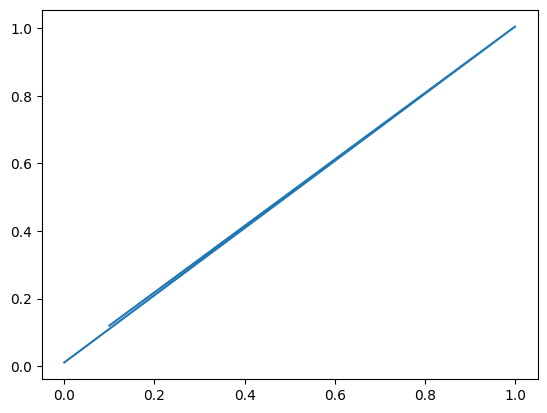

In [7]:
plt.plot(rk4_particle_sol[1][0],rk4_particle_sol[1][1])

In [8]:
rk4_tokamak_sol = rk4(10**3, 0.1, v0_tokamak, x0_tokamak, B_tokamak, A_tokamak, U_tokamak, gradU_tokamak)

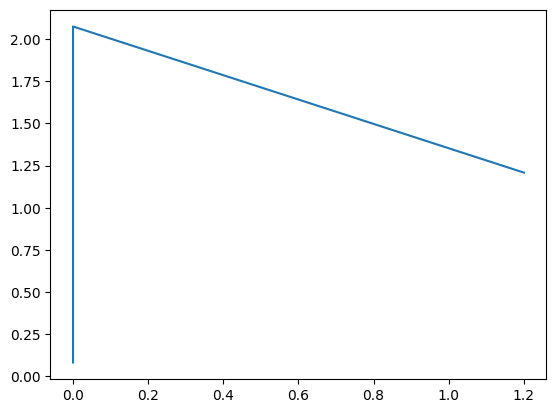

In [9]:
plt.plot(rk4_tokamak_sol[1][0], rk4_tokamak_sol[1][1])

In [10]:
from scipy.integrate import solve_ivp


# uses solve_ivp to get the initial n points of the solution
def initial_soln(x0, v0, B, gradU, h, n):
    # we need to unpack and repack x, v since solve_ivp can't handle nested arrays
    def f(t, y):
        x = np.array(y[:3])
        v = np.array(y[3:])
        x2 = v
        v2 = np.cross(v, B(x)) - gradU(x)
        return [*x2, *v2]
    
    ts = [k * h for k in range(n)] # we only want the soln at these points
    res = solve_ivp(f, (0, h*n), [*x0, *v0], t_eval=ts, rtol=1e-10, atol=1e-12)
    x = res.y[:3].transpose()
    v = res.y[3:].transpose()
    return x, v



In [34]:
from math import sqrt, atan2
from autograd import jacobian

# Generated using Sage:
# A_particle = (-y * sqrt(x^2 + y^2), x * sqrt(x^2 + y^2), 0)
# A_tokamak = (0, (1/2) * (x - log(sqrt(x^2 + y^2) + x)), -(1/2) * (z * arctan(y/x) + log(x^2 + y^2)))
# jacobian(A_particle, (x, y, z))
# jacobian(A_tokamak, (x, y, z))
"""
def A_particle_jacobian(p):
    x, y, _ = p
    M = [[-x*y/sqrt(x**2 + y**2), -y**2/sqrt(x**2 + y**2) - sqrt(x**2 + y**2,), 0],
         [x**2/sqrt(x**2 + y**2) + sqrt(x**2 + y**2), x*y/sqrt(x**2 + y**2), 0],
         [0, 0, 0]]
    return np.array(M)


def A_tokamak_jacobian(p):
    x, y, z = p
    M = [[0, 0, 0],
         [-1/2*(x/sqrt(x**2 + y**2) + 1)/(x + sqrt(x**2 + y**2)) + 1/2, -1/2*y/(sqrt(x**2 + y**2)*(x + sqrt(x**2 + y**2))), 0],
         [-x/(x**2 + y**2) + 1/2*y*z/(x**2*(y**2/x**2 + 1)), -y/(x**2 + y**2) - 1/2*z/(x*(y**2/x**2 + 1)), -1/2*atan2(y, x)]]
    return np.array(M)
"""

A_particle_jacobian = jacobian(A_particle)
A_tokamak_jacobian = jacobian(A_tokamak)

# calculates the five-point central difference of the array y at j
def Δ(y, j, f=lambda x: x):
    return (1/12) * (f(y[j-2]) - 8*f(y[j-1]) + 8*f(y[j+1]) - f(y[j+2]))


def fourth_order_multistep(x0, v0, B, A, A_diff, gradU, h, n):
    def F(j, x, v):
        v[j] = Δ(x, j)/h
        A_delta_j = Δ(x, j, A)/h

        F_j = A_diff(x[j]).transpose() @ v[j] - A_delta_j - gradU(x[j])
        return F_j


    a1, a2, a3 = -0.7, 0.1, 0.9
    beta0 = (1/3) * (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52)
    beta1 = (1/3) * (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38)
    alpha = (1, -7/5, 9/25, 22/125, -34/125, 22/125, 9/25, -7/5, 1)

    x, v = initial_soln(x0, v0, B, gradU, h, 8) # get initial 8 points

    # pad with zeroes on the right
    x = np.pad(x, ((0, n-8), (0, 0)))
    v = np.pad(v, ((0, n-8), (0, 0)))
    assert v.shape == x.shape == (n, 3)

    for n in range(4, n-4):
        other_xs = sum(alpha[j+4]*x[n+j] for j in range(-4, 4))  # note that j = 4 is not included in this sum
        Fnmin1 = F(n-1, x, v)
        Fn = F(n, x, v)
        Fnplus1 = F(n+1, x, v)
        x[n+4] = h**2 * (beta1 * Fnmin1 + beta0*Fn + beta1*Fnplus1) - other_xs
    
    return x, v

x, v = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, 0.1, 10)


In [33]:
from autograd import grad, jacobian

A_particle_jac = jacobian(A_particle)
print(A_particle_jac(np.array([1.0, 1.0, 1.0])))

print(A_particle_jacobian(np.array([1., 1., 1.])))

#grad_A = grad(A_particle)
#grad_A(np.array([1., 1., 1.]))

[[-0.23570226 -0.70710678  0.        ]
 [ 0.70710678  0.23570226  0.        ]
 [ 0.          0.          0.        ]]
[[-0.70710678 -2.12132034  0.        ]
 [ 2.12132034  0.70710678  0.        ]
 [ 0.          0.          0.        ]]


In [37]:
x, v = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, 0.1, 20)

print(x)
print(v)

[[0.         1.         0.1       ]
 [0.00923696 1.00459109 0.12      ]
 [0.01889365 1.00833154 0.14      ]
 [0.02888462 1.01117888 0.16      ]
 [0.03911975 1.01310016 0.18      ]
 [0.04950544 1.01407261 0.2       ]
 [0.05994584 1.01408401 0.22      ]
 [0.0703442  1.01313295 0.24      ]
 [0.08060376 1.0112303  0.26      ]
 [0.09063031 1.00839539 0.28      ]
 [0.10033385 1.00465886 0.3       ]
 [0.10962634 1.00006049 0.32      ]
 [0.11842548 0.9946484  0.34      ]
 [0.12665676 0.9884818  0.36      ]
 [0.13425094 0.98162661 0.38      ]
 [0.14114923 0.97415374 0.4       ]
 [0.14730028 0.96614097 0.42      ]
 [0.15266083 0.95766938 0.44      ]
 [0.15719832 0.94882227 0.46      ]
 [0.1608886  0.9396858  0.48      ]]
[[ 0.09        0.05        0.2       ]
 [ 0.09460623  0.04173614  0.2       ]
 [ 0.09838497  0.03300201  0.2       ]
 [ 0.10128362  0.02388951  0.2       ]
 [ 0.10326198  0.01449782  0.2       ]
 [ 0.10429095  0.00493057  0.2       ]
 [ 0.10435508 -0.00470618  0.2       ]
 [ 0.1

In [36]:
x, v = initial_soln(x0_particle, v0_particle, B_particle, gradU_particle, 0.1, 20)
print(x)
#print(v)

[[0.         1.         0.1       ]
 [0.00923696 1.00459109 0.12      ]
 [0.01889365 1.00833154 0.14      ]
 [0.02888462 1.01117888 0.16      ]
 [0.03911975 1.01310016 0.18      ]
 [0.04950544 1.01407261 0.2       ]
 [0.05994584 1.01408401 0.22      ]
 [0.0703442  1.01313295 0.24      ]
 [0.0806042  1.01122889 0.26      ]
 [0.09063127 1.00839198 0.28      ]
 [0.10033393 1.00465278 0.3       ]
 [0.10962499 1.00005168 0.32      ]
 [0.11842271 0.99463827 0.34      ]
 [0.12665176 0.9884705  0.36      ]
 [0.13424416 0.98161372 0.38      ]
 [0.14113993 0.9741397  0.4       ]
 [0.14728769 0.96612545 0.42      ]
 [0.15264498 0.95765215 0.44      ]
 [0.15717854 0.94880397 0.46      ]
 [0.16086429 0.93966698 0.48      ]]
